In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from skimage import io
from IPython.display import clear_output

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

# Exploratory Data Analysis

In [4]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
91151,00022726_007.png,No Finding,7,22726,45,F,PA,2870,2793,0.143,0.143,NaN
16035,00004269_001.png,Effusion,1,4269,38,M,PA,2500,2048,0.168,0.168,NaN
93015,00023220_000.png,No Finding,0,23220,45,F,PA,2710,2991,0.143,0.143,NaN


In the NIH data, there is an 'Unnamed' column. We will remove that column from our data. 

In [5]:
all_xray_df = all_xray_df.loc[:, ~all_xray_df.columns.str.contains('^Unnamed')]
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
51434,00012993_020.png,Atelectasis,20,12993,34,M,AP,2500,2048,0.168,0.168
82343,00020249_006.png,No Finding,6,20249,26,F,AP,3056,2544,0.139,0.139
76083,00018665_000.png,Infiltration,0,18665,60,M,PA,2992,2991,0.143,0.143


In [6]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3212,00015809_009.png,No Finding,9,15809,037Y,F,PA,2992,2991,0.143,0.143
1528,00007992_002.png,No Finding,2,7992,019Y,M,PA,2048,2500,0.168,0.168
2682,00013572_009.png,No Finding,9,13572,061Y,F,PA,2048,2500,0.168,0.168


I'm going to split up my "Finding Labels" column so that I have one column in my dataframe per disease, with a binary flag. 

In [7]:
all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print("Number of labels: {}\nLabels: {}".format(len(all_xray_labels),", ".join(all_xray_labels)))
for c_label in all_xray_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

Number of labels: 15
Labels: Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, No Finding, Nodule, Pleural_Thickening, Pneumonia, Pneumothorax


# AGE
Now let's move on to looking at age.

First, we can see that there are some patients with age > 100 (even 400). There might be something wrong with the dataset (or they actually live that long). I will remove these patients from our data to have a better visualization of the ages.

In [8]:
all_xray_df.loc[all_xray_df['Patient Age']>100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

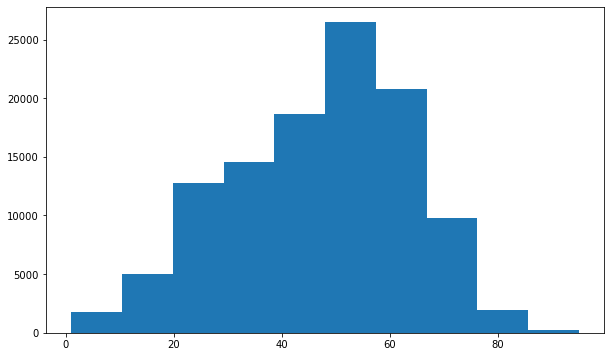

In [9]:
plt.figure(figsize=(10,6))
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] < 100]
plt.hist(all_xray_df['Patient Age'])

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

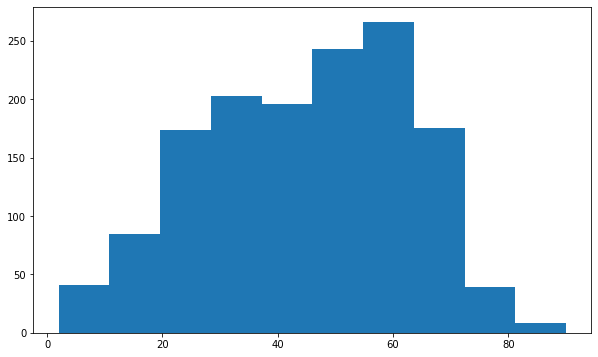

In [10]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])

Most of our Pneumonia Patient are in the age from 20 - 70 with the peak at around 60



# Gender

Now let's move on to looking at gender.

In [11]:
colors_list = ['#5bc0de','#d9534f']

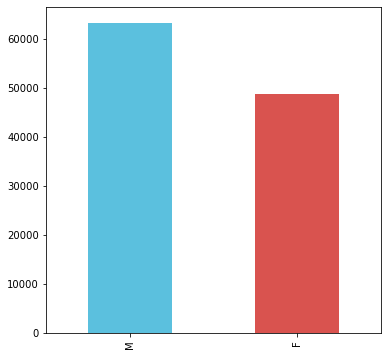

In [12]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar', color=colors_list)

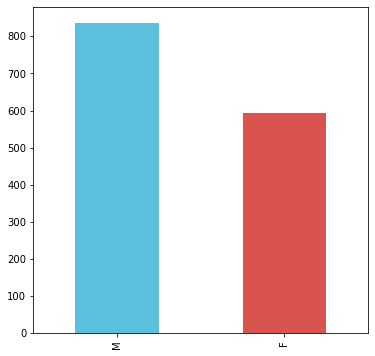

In [13]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar', color=colors_list)

Gender distribution seems to have a preference towards AP in the whole population as well as with Pneumonia

# View Position

Now let's move on to looking at view position.

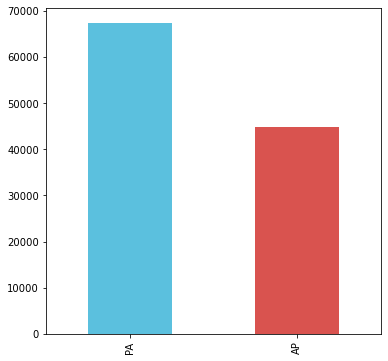

In [14]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar', color = colors_list)

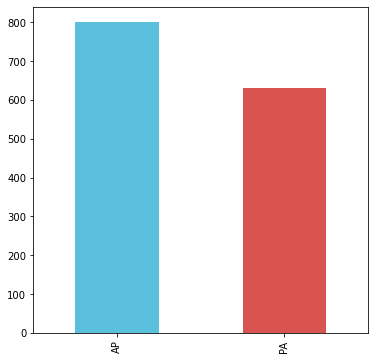

In [15]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar', color = colors_list)

View Position distribution seems to have a preference towards AP in the whole population as well as with Pneumonia

# DISEASES DISTRIBUTION

[Text(0, 0.5, 'Number of Images with Label')]

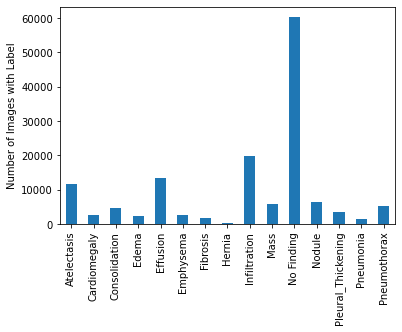

In [16]:
ax = all_xray_df[all_xray_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [17]:
# Number of patients for each diseases
all_xray_df[all_xray_labels].sum()

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

In [18]:
# Percentage of each diseases in the whole data
all_xray_df[all_xray_labels].sum()/len(all_xray_df)*100

Atelectasis           10.310069
Cardiomegaly           2.476272
Consolidation          4.163099
Edema                  2.053450
Effusion              11.878256
Emphysema              2.244345
Fibrosis               1.503961
Hernia                 0.202491
Infiltration          17.743345
Mass                   5.155035
No Finding            53.836616
Nodule                 5.647435
Pleural_Thickening     3.018626
Pneumonia              1.275601
Pneumothorax           4.728645
dtype: float64

In [19]:
# Number of pneumonia cases
num_pneumonia = all_xray_df['Pneumonia'].sum()
print("Number of pneumonia cases: {}".format(num_pneumonia))

# Number of non-pneumonia cases and has other disease
num_non_pneumonia = len(all_xray_df.loc[(all_xray_df['Pneumonia']==0) & (all_xray_df['No Finding']!=0)])
print("Number of non-pneumonia cases: {}".format(num_non_pneumonia))

Number of pneumonia cases: 1430.0
Number of non-pneumonia cases: 60353


Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

The number of Pneumonia only accounts 1.28% (1431 cases) of our data set.
The number of patients who don't have Pneumonia cases but other diseases is 60353.

I'm going to now look at how frequently it appears with all of the other diseases. Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:

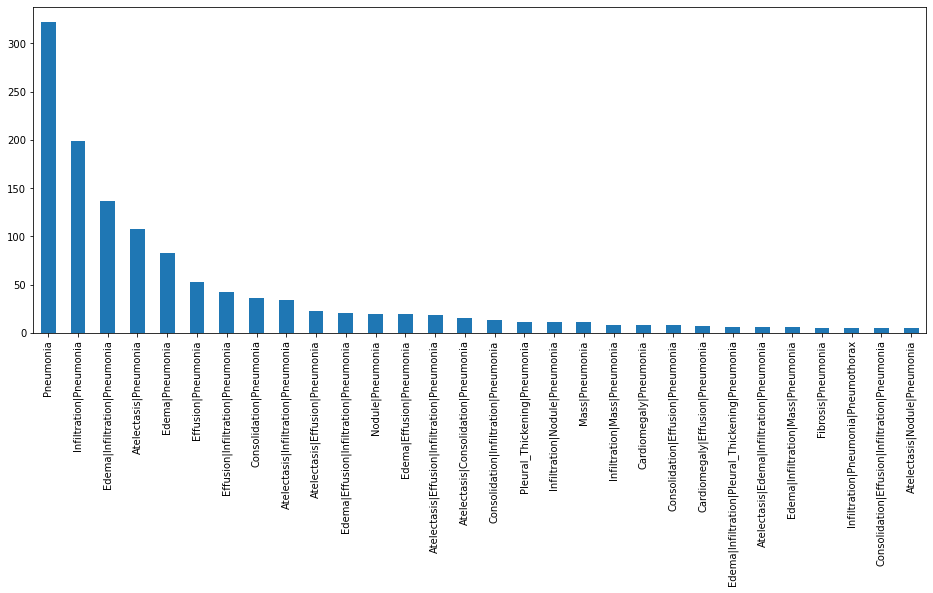

In [20]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like Pneunomia actually occurs alone for the most part, and that its most-common comorbidities are Infiltration, Edema, Atelectasis, Consolidation, and Effusion.

# NUMBER OF DISEASES PER PERSON

Number of Diseases
0.0    60353
1.0    30959
2.0    14302
3.0     4856
4.0     1247
5.0      301
6.0       67
7.0       16
8.0        1
9.0        2
Name: Number of Diseases, dtype: int64


[Text(0, 0.5, 'Number of Patients')]

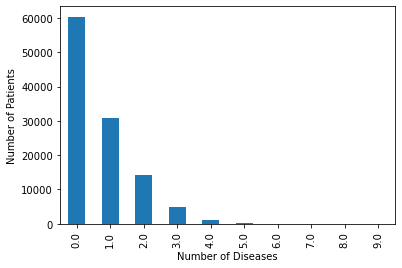

In [21]:
number_of_diseases_per_person = all_xray_df.iloc[:,11:].sum(axis=1) - all_xray_df['No Finding']
df = pd.DataFrame(number_of_diseases_per_person, columns=['Number of Diseases'])

group_number = df.groupby("Number of Diseases")["Number of Diseases"].count()
print(group_number)

ax = group_number.plot(kind = 'bar')
ax.set(ylabel = 'Number of Patients')

We can see that most of the patients does not have any diseases (No Finding result). Beyond that, most of the patients have 1 or 2 diseases.

# PIXEL LEVEL ASSESSMENT

In [22]:
# Visualize some images
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    clear_output(wait=True)
    path = glob(os.path.join("/data","images*","*",img_id))[0]
    print("Loaded {}/{}".format(i+1, len(sample_df)))
    img = io.imread(path)
    images.append(img)

Loaded 5606/5606


In [23]:
def sample_stack(images, rows=7, cols=7, start_with=0, show_every=100):
    fig,ax = plt.subplots(rows,cols,figsize=[15,15])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('Image %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(images[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

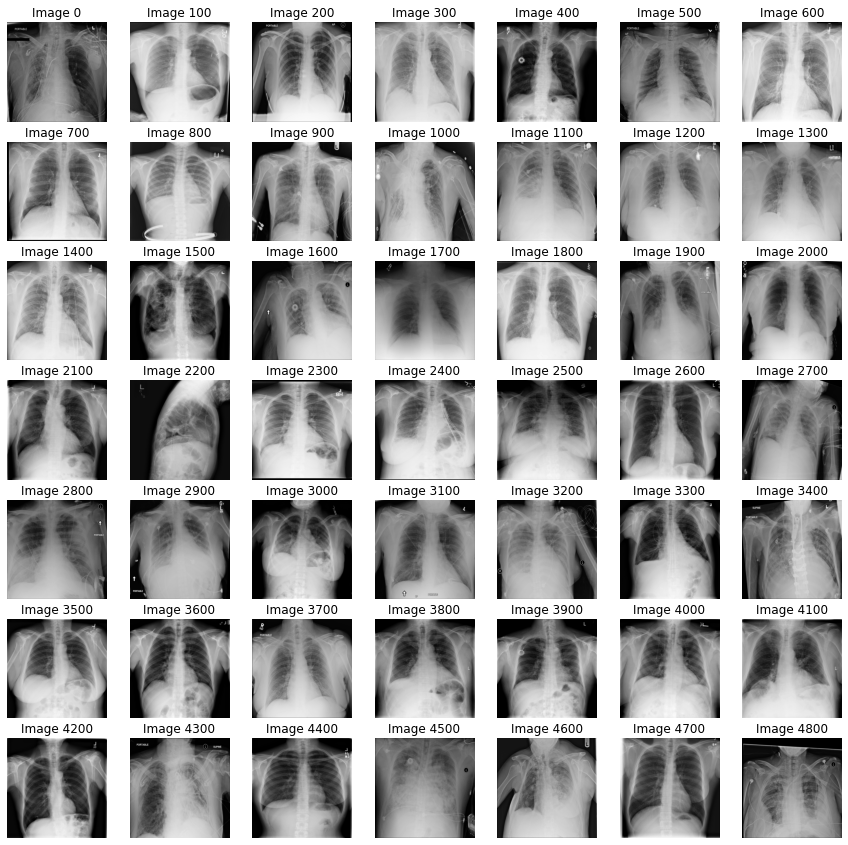

In [24]:
sample_stack(images)

In [25]:
def normalize_image(image):
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_image = image.copy()
    new_image = (new_image - mean_intensity)/std_intensity
    return new_image

In [ ]:
# new_images = []
# for i, image in enumerate(images):
#     clear_output(wait=True)
#     new_images.append(normalize_image(image))
#     print("Normalized {}/{}".format(i+1, len(images)))

In [27]:
intensity_images = []
for i, image in enumerate(images):
    clear_output(wait=True)
    intensity_images.append(np.mean(image))
    print("Done {}/{}".format(i, len(images)))
intensity_images = np.array(intensity_images)

Done 5605/5606


In [28]:
pneumonia_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]

(array([ 4.,  8., 16., 13., 10.,  4.,  0.,  3.,  3.,  1.]),
 array([ 88.1964426 ,  98.5581321 , 108.9198216 , 119.28151109,
        129.64320059, 140.00489008, 150.36657958, 160.72826908,
        171.08995857, 181.45164807, 191.81333756]),
 <a list of 10 Patch objects>)

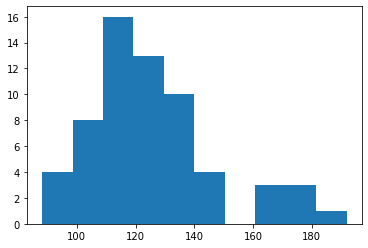

In [30]:
plt.hist(pneumonia_intensity)

The distribution of the pixel intesity value of Pneumonia Patient ranges between 100 and 140 with a peak around 120.

Let have a look at the intesity of patients with Infiltration and Effusion

(array([  3.,   6.,  14.,  67., 341., 272., 143.,  91.,  23.,   7.]),
 array([ 41.29449272,  56.17974558,  71.06499844,  85.95025129,
        100.83550415, 115.72075701, 130.60600986, 145.49126272,
        160.37651558, 175.26176844, 190.14702129]),
 <a list of 10 Patch objects>)

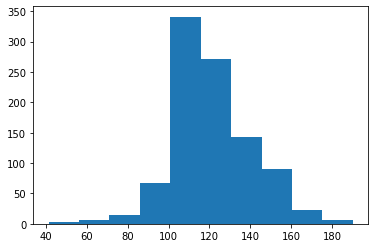

In [31]:
infiltration_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
plt.hist(infiltration_intensity)

(array([  3.,   6.,  14.,  67., 341., 272., 143.,  91.,  23.,   7.]),
 array([ 41.29449272,  56.17974558,  71.06499844,  85.95025129,
        100.83550415, 115.72075701, 130.60600986, 145.49126272,
        160.37651558, 175.26176844, 190.14702129]),
 <a list of 10 Patch objects>)

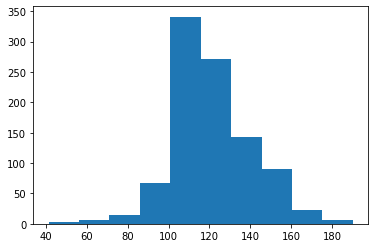

In [32]:
effusion_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
plt.hist(effusion_intensity)

These distributions are quite similar to Pneumonia. They also range from 100 to 140 with a peak near 120.

Let have a look at the intensity over all images in our data.

(array([   9.,   21.,   88.,  715., 2131., 1255.,  702.,  575.,  102.,
           8.]),
 array([ 37.45602131,  54.76187196,  72.06772261,  89.37357326,
        106.6794239 , 123.98527455, 141.2911252 , 158.59697585,
        175.9028265 , 193.20867715, 210.5145278 ]),
 <a list of 10 Patch objects>)

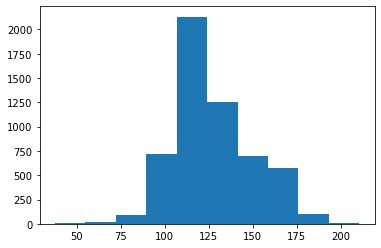

In [33]:
plt.hist(intensity_images)

The intesity range from 100 to 150, with a peak at around 110.

# Conclusion


From the above findings, we can build our model to train on the following properties of a patient:
    - The age, gender
    - The X-ray view position
    - The intensity value of each image

Moreover, we also need to do some pre-processing of our images: remove some of unnecessary columns when feeding the data into the network, balance the number of non-pneumonia and pneumonia cases, normalize the images.